In [1]:
from matplotlib import pyplot
from pandas import read_csv, DataFrame, Series, isnull
from numpy import quantile, nan, concatenate, log

In [2]:
features = read_csv('omni_v2_sample_metadata_Sheet1.tsv', header=0, sep='\t')
features.head(2)

,run_sample_id,index,index2,sample_sheet,accession_id,PlateWell_ID,batch_name,flowcell_ID,input_ng_PG,input_ng_TS,...,Sample_Type,cancer_type,bait_ng,bait_blending,MBDS_buffer_mM,methyl-carrier,MW1_buffer_mM,MSRE,LP_200_800bp_Hypo_ng_uL,LP_200_800bp_Hyper_ng_uL
0,C0013809,CGCTCAATGG,CAAGGCGCGC,210322_A01021_0237_AH2N5MDSX2_CMRDNHLA.csv,NaN,NaN,OMNI_001,H2N5MDSX2,10,10.0,...,PCR Refresh,normal,20.20,100_1,NaN,NaN,NaN,NaN,NaN,NaN
1,C0013810,TCATAGAGCG,CATTTCAGGG,210322_A01021_0237_AH2N5MDSX2_CMRDNHLA.csv,NaN,NaN,OMNI_001,H2N5MDSX2,10,10.0,...,PCR Refresh,normal,20.25,80_1,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
features["input_ng_PG"].value_counts()

25.0     179
#NUM!     72
15.0      45
100       36
10        36
        ... 
33.7       1
33.8       1
27.3       1
36.2       1
60.3       1
Name: input_ng_PG, Length: 146, dtype: int64

In [28]:
mdata = read_csv('counting-output/l2_counts.tsv', header=0, sep='\t')
mdata = mdata.T
mdata.columns = mdata.iloc[0].to_list()
mdata = mdata.iloc[1:]
region_list = mdata.columns.to_list()[:-1]
mdata["MSRE"] = nan
for idx, d2 in mdata.iterrows():
    mdata.loc[idx, "MSRE"] = features[features["run_sample_id"]==idx]["MSRE"].item()
mdata.head(2)

,1_10002945_10003896,1_100315326_100316120,1_1003813_1004865,1_100435187_100436167,1_100503312_100504500,1_10057059_10058046,1_100598041_100598939,1_100714848_100715562,1_100731266_100732388,1_100817690_100819049,...,Y_21728794_21730239,Y_21906086_21907084,Y_2709417_2710095,Y_2802900_2804561,Y_6777175_6777489,Y_6778279_6779833,Y_7140665_7141373,Y_7141558_7143307,ctrl_sum,MSRE
C0018262,5,7,16,11,8,27,14,3,14,11,...,0,0,0,0,0,0,0,0,131897,MSRE(-)
C0018225,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,71197,MSRE(+)


In [29]:
mdata["MSRE"].value_counts()

MSRE(+)    47
MSRE(-)    47
Name: MSRE, dtype: int64

In [32]:
clean_regions = []
for r in region_list:
    if "X" in r or "Y" in r:
        continue
    clean_regions.append(r)

In [34]:
from umap import UMAP
reducer = UMAP()
embedding = reducer.fit_transform(mdata[clean_regions])

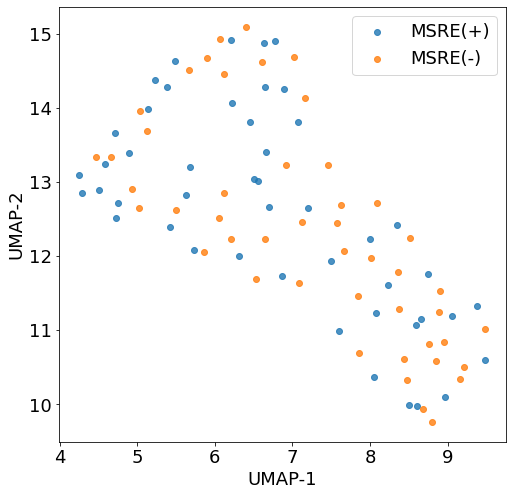

In [37]:
pyplot.rcParams['figure.figsize'] = [8, 8]
pyplot.rcParams.update({'font.size': 18})
msre_status = list(set(mdata["MSRE"].tolist()))
for ms in msre_status:
    _ = pyplot.scatter(embedding[mdata["MSRE"]==ms,0], embedding[mdata["MSRE"]==ms,1], alpha=0.8, label=ms)
_ = pyplot.xlabel("UMAP-1", fontsize=18)
_ = pyplot.ylabel("UMAP-2", fontsize=18)
_ = pyplot.legend()

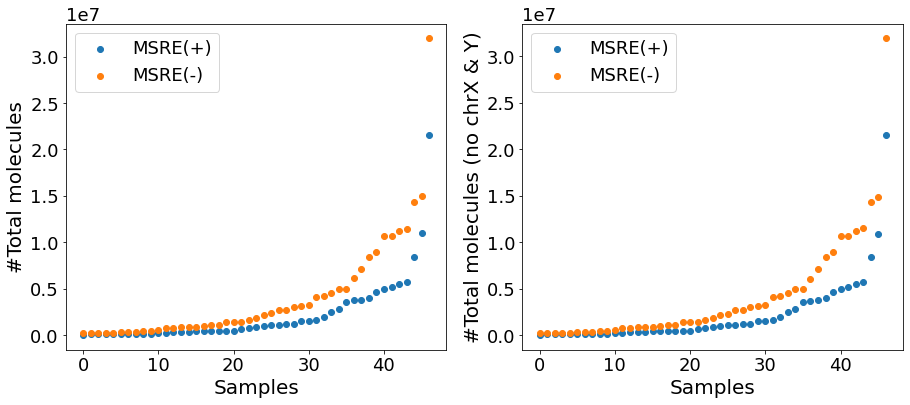

In [39]:
## on-target molecules per sample: filtered by MAPQ in BIP
pyplot.rcParams['figure.figsize'] = [15, 6]

_ = pyplot.subplot(1,2,1)
for ms in msre_status:
    pd = mdata[mdata["MSRE"]==ms]
    _ = pyplot.scatter(range(pd.shape[0]), sorted(pd[region_list].sum(axis=1)), label=ms)
_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Total molecules", fontsize=20)
_ = pyplot.legend()

_ = pyplot.subplot(1,2,2)
for ms in msre_status:
    pd = mdata[mdata["MSRE"]==ms]
    _ = pyplot.scatter(range(pd.shape[0]), sorted(pd[clean_regions].sum(axis=1)), label=ms)
_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Total molecules (no chrX & Y)", fontsize=20)
_ = pyplot.legend()

In [40]:
## family size
indata = read_csv('counting-output/om009-family-offtarget.csv', header=0, sep='\t')
indata["MSRE"] = nan
for idx, d2 in indata.iterrows():
    indata.loc[idx, "MSRE"] = features[features["run_sample_id"]==d2["sample"]]["MSRE"].item()
indata.head(2)

,sample,ontarget_sum,ontarget_fam_size,offtarget_sum,offtarget_fam_size,MSRE
0,C0018190,7686.0,12.842441,20589.0,1.758524,MSRE(+)
1,C0018191,226218.0,10.812808,7080088.0,2.007263,MSRE(+)


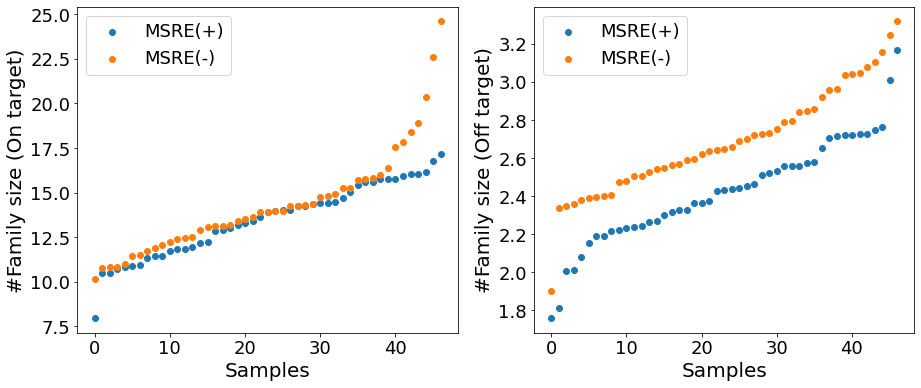

In [42]:
pyplot.rcParams['figure.figsize'] = [15, 6]
_ = pyplot.subplot(1,2,1)
for ms in msre_status:
    pd = indata[indata["MSRE"]==ms]
    _ = pyplot.scatter(range(pd.shape[0]), sorted(pd["ontarget_fam_size"]), label=ms)
_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Family size (On target)", fontsize=20)
_ = pyplot.legend()

_ = pyplot.subplot(1,2,2)
for ms in msre_status:
    pd = indata[indata["MSRE"]==ms]
    _ = pyplot.scatter(range(pd.shape[0]), sorted(pd["offtarget_fam_size"]), label=ms)

_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Family size (Off target)", fontsize=20)
_ = pyplot.legend()

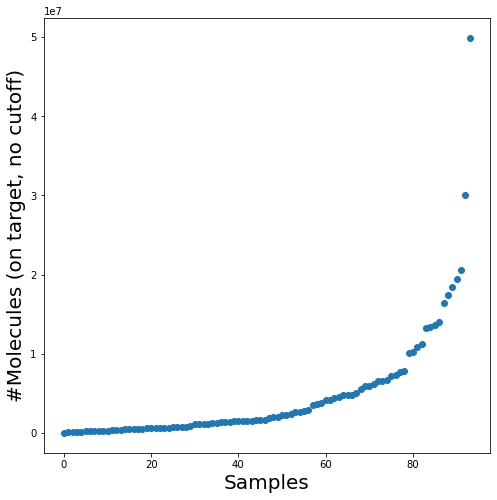

In [13]:
## on-target molecules: sanity check, no mapq so different from the previous...
pyplot.rcParams['figure.figsize'] = [8, 8]
_ = pyplot.scatter(range(indata.shape[0]), sorted(indata["ontarget_sum"]))
_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Molecules (on target, no cutoff)", fontsize=20)

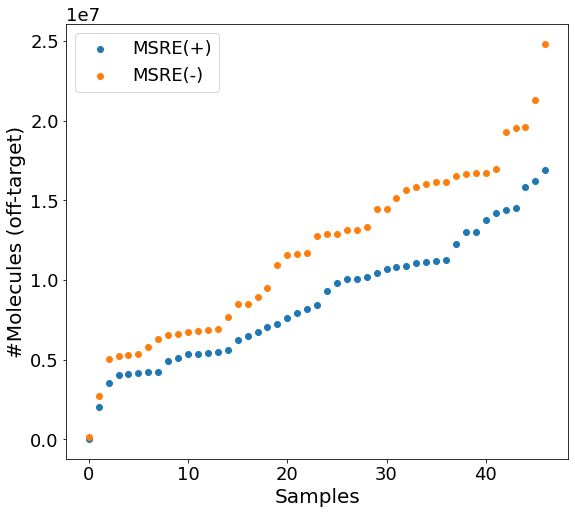

In [44]:
## off-target molecules
pyplot.rcParams['figure.figsize'] = [9, 8]
for ms in msre_status:
    pd = indata[indata["MSRE"]==ms]
    _ = pyplot.scatter(range(pd.shape[0]), sorted(pd["offtarget_sum"]), label=ms)

_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Molecules (off-target)", fontsize=20)
_ = pyplot.legend()

In [ ]:
%%bash
less /ghds/omni_v2/tool/post-bip_resource/bip-products/panels/LDT_next_v1.0/MBD_control.bed | \
 grep HYPO_CONTROL | cut -f1-3 > raw-v6_hypo_ctrl.bed
cat /ghds/groups/algorithms/scratch/tjiang/methylome/Resource/methylome_region/hyper_validated_targets_with_control.tsv | \
 awk 'NR>1' | bedtools sort -i - | bedtools intersect -a - -b raw-v6_hypo_ctrl.bed -u > v6_hypo_ctrl.bed


In [61]:
hypo_regions = []
incsv = read_csv('v6_hypo_ctrl.bed', header=None, sep='\t')
for idx, d2 in incsv.iterrows():
    hypo_regions.append('_'.join(map(str, d2[:3])))
print(len(hypo_regions))

479


In [62]:
# normalized mol on hypo control by positive control or input (ng)
mdata["input"] = nan
for idx, d2 in mdata.iterrows():
    mdata.loc[idx, "input"] = features[features["run_sample_id"]==idx]["input_ng_TS"].item()
mdata.head(2)

,1_10002945_10003896,1_100315326_100316120,1_1003813_1004865,1_100435187_100436167,1_100503312_100504500,1_10057059_10058046,1_100598041_100598939,1_100714848_100715562,1_100731266_100732388,1_100817690_100819049,...,Y_21906086_21907084,Y_2709417_2710095,Y_2802900_2804561,Y_6777175_6777489,Y_6778279_6779833,Y_7140665_7141373,Y_7141558_7143307,ctrl_sum,MSRE,input
C0018262,5,7,16,11,8,27,14,3,14,11,...,0,0,0,0,0,0,0,131897,MSRE(-),22.2
C0018225,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,71197,MSRE(+),14.9


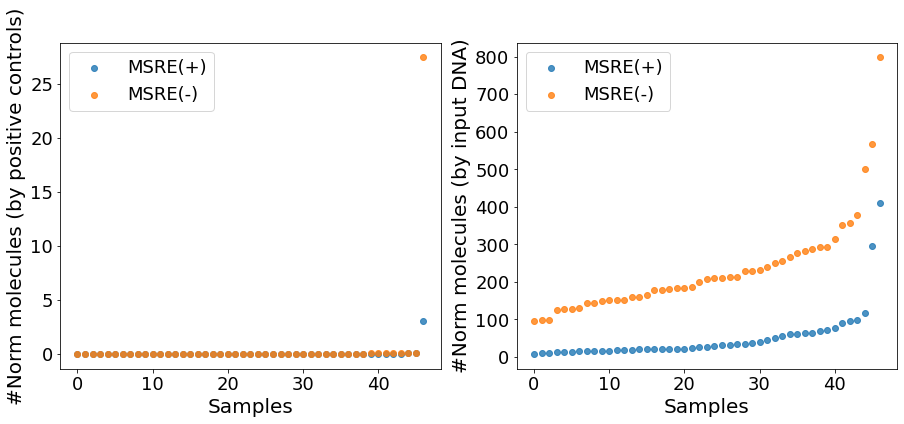

In [69]:
pyplot.rcParams['figure.figsize'] = [15, 6]
_ = pyplot.subplot(1,2,1)
for ms in msre_status:
    pd = mdata[mdata["MSRE"]==ms]
    ct =  [i / j for i, j in zip(pd[hypo_regions].sum(axis=1).to_list(), pd["ctrl_sum"].to_list())]
    _ = pyplot.scatter(range(pd.shape[0]), sorted(ct), alpha=0.8, label=ms)
_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Norm molecules (by positive controls)", fontsize=20)
_ = pyplot.legend()

_ = pyplot.subplot(1,2,2)
for ms in msre_status:
    pd = mdata[mdata["MSRE"]==ms]
    ct =  [i / j for i, j in zip(pd[hypo_regions].sum(axis=1).to_list(), pd["input"].to_list())]
    _ = pyplot.scatter(range(pd.shape[0]), sorted(ct), alpha=0.8, label=ms)
_ = pyplot.xlabel("Samples", fontsize=20)
_ = pyplot.ylabel("#Norm molecules (by input DNA)", fontsize=20)
_ = pyplot.legend()

In [73]:
# get the abnormal sample out: looks like both have very low positive counts...should look into this
for idx, pd in mdata.iterrows():
    nct = sum(pd[hypo_regions]) / pd["ctrl_sum"]
    if nct > 3:
        print(mdata.loc[idx,])

1_10002945_10003896           10
1_100315326_100316120          6
1_1003813_1004865              9
1_100435187_100436167         13
1_100503312_100504500         15
                          ...   
Y_7140665_7141373              2
Y_7141558_7143307              5
ctrl_sum                     274
MSRE                     MSRE(-)
input                       15.0
Name: C0018238, Length: 18762, dtype: object
1_10002945_10003896            0
1_100315326_100316120          2
1_1003813_1004865              0
1_100435187_100436167          2
1_100503312_100504500          0
                          ...   
Y_7140665_7141373              0
Y_7141558_7143307              0
ctrl_sum                      90
MSRE                     MSRE(+)
input                       15.0
Name: C0018190, Length: 18762, dtype: object


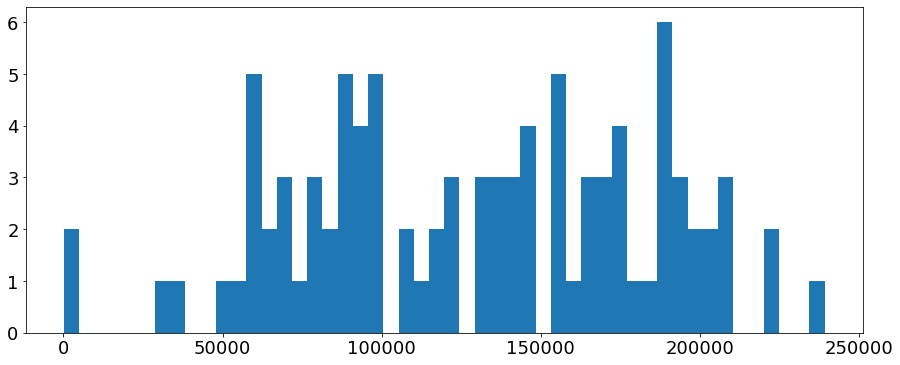

In [76]:
_ = pyplot.hist(mdata["ctrl_sum"], bins=50)

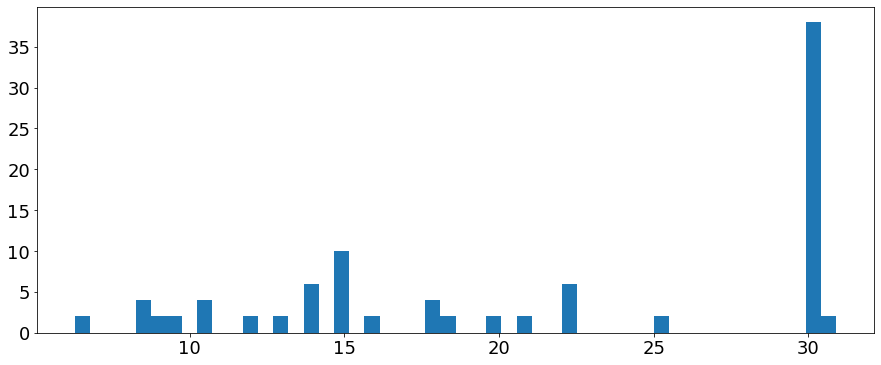

In [77]:
_ = pyplot.hist(mdata["input"], bins=50)